In [67]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from typing import List, Annotated, TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import pandas as pd
import os
import ast

_ = load_dotenv()
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)


In [68]:
class AgentState(TypedDict):
    messages: Annotated[list[dict], operator.add]
    risultati_generati: dict
    critica: str
    max_revisions: int
    revision_number: int

In [69]:
expected_columns = {
    "id": {"type": int, "min": 0, "max": None},
    "NumDots": {"type": int, "min": 0, "max": None},
    "SubdomainLevel": {"type": int, "min": 0, "max": None},
    "PathLevel": {"type": int, "min": 0, "max": None},
    "UrlLength": {"type": int, "min": 0, "max": None},
    "NumDash": {"type": int, "min": 0, "max": None},
    "NumDashInHostname": {"type": int, "min": 0, "max": None},
    "AtSymbol": {"type": int, "min": 0, "max": 1},
    "TildeSymbol": {"type": int, "min": 0, "max": 1},
    "NumUnderscore": {"type": int, "min": 0, "max": None},
    "NumPercent": {"type": int, "min": 0, "max": None},
    "NumQueryComponents": {"type": int, "min": 0, "max": None},
    "NumAmpersand": {"type": int, "min": 0, "max": None},
    "NumHash": {"type": int, "min": 0, "max": None},
    "NumNumericChars": {"type": int, "min": 0, "max": None},
    "NoHttps": {"type": int, "min": 0, "max": 1},
    "RandomString": {"type": int, "min": 0, "max": 1},
    "IpAddress": {"type": int, "min": 0, "max": 1},
    "DomainInSubdomains": {"type": int, "min": 0, "max": 1},
    "DomainInPaths": {"type": int, "min": 0, "max": 1},
    "HttpsInHostname": {"type": int, "min": 0, "max": 1},
    "HostnameLength": {"type": int, "min": 0, "max": None},
    "PathLength": {"type": int, "min": 0, "max": None},
    "QueryLength": {"type": int, "min": 0, "max": None},
    "DoubleSlashInPath": {"type": int, "min": 0, "max": 1},
    "NumSensitiveWords": {"type": int, "min": 0, "max": None},
    "EmbeddedBrandName": {"type": int, "min": 0, "max": 1},
    "PctExtHyperlinks": {"type": float, "min": 0.0, "max": 1.0},
    "PctExtResourceUrls": {"type": float, "min": 0.0, "max": 1.0},
    "ExtFavicon": {"type": int, "min": 0, "max": 1},
    "InsecureForms": {"type": int, "min": 0, "max": 1},
    "RelativeFormAction": {"type": int, "min": 0, "max": 1},
    "ExtFormAction": {"type": int, "min": 0, "max": 1},
    "AbnormalFormAction": {"type": int, "min": 0, "max": 1},
    "PctNullSelfRedirectHyperlinks": {"type": float, "min": 0.0, "max": 1.0},
    "FrequentDomainNameMismatch": {"type": int, "min": 0, "max": 1},
    "FakeLinkInStatusBar": {"type": int, "min": 0, "max": 1},
    "RightClickDisabled": {"type": int, "min": 0, "max": 1},
    "PopUpWindow": {"type": int, "min": 0, "max": 1},
    "SubmitInfoToEmail": {"type": int, "min": 0, "max": 1},
    "IframeOrFrame": {"type": int, "min": 0, "max": 1},
    "MissingTitle": {"type": int, "min": 0, "max": 1},
    "ImagesOnlyInForm": {"type": int, "min": 0, "max": 1},
    "SubdomainLevelRT": {"type": int, "min": 0, "max": None},
    "UrlLengthRT": {"type": int, "min": 0, "max": None},
    "PctExtResourceUrlsRT": {"type": float, "min": 0.0, "max": 1.0},
    "AbnormalExtFormActionR": {"type": int, "min": 0, "max": 1},
    "ExtMetaScriptLinkRT": {"type": int, "min": 0, "max": 1},
    "PctExtNullSelfRedirectHyperlinksRT": {"type": float, "min": 0.0, "max": 1.0},
    "CLASS_LABEL": {"type": int, "min": -1, "max": 1},
}


In [70]:
GENERATOR_PROMPT = """You are a data generator. 
Your task is to generate 1 sample based on the information I will provide. 
The dataset you must generate is about phishing and legit websites. The columns are:

id, NumDots, SubdomainLevel, PathLevel, UrlLength, NumDash, NumDashInHostname, AtSymbol, TildeSymbol, NumUnderscore, NumPercent, NumQueryComponents, NumAmpersand, NumHash, NumNumericChars, NoHttps, RandomString, IpAddress, DomainInSubdomains, DomainInPaths, HttpsInHostname, HostnameLength, PathLength, QueryLength, DoubleSlashInPath, NumSensitiveWords, EmbeddedBrandName, PctExtHyperlinks, PctExtResourceUrls, ExtFavicon, InsecureForms, RelativeFormAction, ExtFormAction, AbnormalFormAction, PctNullSelfRedirectHyperlinks, FrequentDomainNameMismatch, FakeLinkInStatusBar, RightClickDisabled, PopUpWindow, SubmitInfoToEmail, IframeOrFrame, MissingTitle, ImagesOnlyInForm, SubdomainLevelRT, UrlLengthRT, PctExtResourceUrlsRT, AbnormalExtFormActionR, ExtMetaScriptLinkRT, PctExtNullSelfRedirectHyperlinksRT, CLASS_LABEL

Examples are:
2, 3, 1, 3, 144, 0, 0, 0, 0, 2, 0, 2, 1, 0, 41, 1, 0, 0, 0, 0, 0, 17, 16, 103, 0, 1, 0, 0.0000000000, 0.0000000000, 0, 1, 0, 0, 0, 0.0000000000, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 1, 1, 1, 1, 1
6434, 3, 1, 1, 143, 10, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 1, 0, 0, 1, 0, 42, 94, 0, 0, 0, 0, 0.1250000000, 0.2093023256, 0, 0, 0, 0, 0, 0.2000000000, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 1, 1, 0, 0, 0

You must respond with data only, without any introductory or explanatory text. 
The structure must be a dictionary-like format because I will use `ast.literal_eval` to parse the data you generate.
"""

def generator_node(state: AgentState):
    messages = [
        SystemMessage(content = GENERATOR_PROMPT),
        HumanMessage(content=f"These are the rules you must follow: {repr(expected_columns)}")
    ]
    
    response = model.invoke(messages)

    return {"risultati_generati": ast.literal_eval(response.content)}

In [71]:
def check_data_entry(data, expected_columns):
    """
    Verifica i tipi di dato e i range di valori per un dizionario `data`.

    :param data: Dizionario contenente i dati da verificare.
    :param expected_columns: Dizionario che definisce i tipi e i range attesi per ogni colonna.
    :return: Lista di problemi riscontrati.
    """
    issues = []
    
    for column, details in expected_columns.items():
        """print(f"column = {column}, type = {type(column)}")
        print("####################### DATA ##########################")
        print(f"data = {data}, type = {type(data)}")"""
        if column not in data:
            issues.append({
                "Column": column,
                "Issue": "Column Missing",
                "Actual Value": None,
                "Expected Type": details["type"]
            })
            continue
        
        value = data[column]
        
        # Controlla il tipo di dato
        if not isinstance(value, details["type"]):
            issues.append({
                "Column": column,
                "Issue": "Type Mismatch",
                "Actual Value": type(value).__name__,
                "Expected Type": details["type"].__name__
            })
        
        # Controlla il range
        if details["min"] is not None and value < details["min"]:
            issues.append({
                "Column": column,
                "Issue": "Value Below Minimum",
                "Actual Value": value,
                "Expected Min": details["min"]
            })
        if details["max"] is not None and value > details["max"]:
            issues.append({
                "Column": column,
                "Issue": "Value Above Maximum",
                "Actual Value": value,
                "Expected Max": details["max"]
            })
            
    return issues

def critique_node(state: AgentState):
    critica = "OK"
    data = state["risultati_generati"]
    issues = check_data_entry(data, expected_columns)
    issues = False
    if issues:
        critica = "NOT OK"
    else:
        print("OKKKK")
        critica = "OK"
        
    return {"critica": critica}

In [72]:
def should_continue(state: AgentState):
    if state["critica"] == "OK":
        return True
    
    if state["revision_number"] > state["max_revisions"] or state["critica"] != "OK":
        return False # torna al nodo di generazione

In [73]:
builder = StateGraph(AgentState)

builder.add_node("generator_node", generator_node)
builder.add_node("critique_node", critique_node)
builder.add_edge("generator_node", "critique_node")
builder.add_conditional_edges("critique_node", should_continue, {True: END, False: "generator_node"})

builder.set_entry_point("generator_node")

graph = builder.compile()

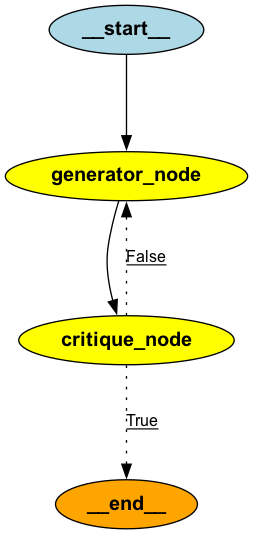

In [74]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [75]:
import pandas as pd

risultati = []

for i in range(2):
    response = graph.invoke(
        {"critica": "",
        "max_revisions": 4,
        "revision_number": 0}
    )
    
    risultati.append(response["risultati_generati"])


OKKKK
OKKKK


In [76]:
for r in risultati:
    print(f"""r = {r} """)

r = {'id': 1234, 'NumDots': 2, 'SubdomainLevel': 1, 'PathLevel': 2, 'UrlLength': 120, 'NumDash': 1, 'NumDashInHostname': 0, 'AtSymbol': 0, 'TildeSymbol': 0, 'NumUnderscore': 1, 'NumPercent': 0, 'NumQueryComponents': 3, 'NumAmpersand': 1, 'NumHash': 0, 'NumNumericChars': 30, 'NoHttps': 1, 'RandomString': 0, 'IpAddress': 0, 'DomainInSubdomains': 0, 'DomainInPaths': 1, 'HttpsInHostname': 1, 'HostnameLength': 15, 'PathLength': 40, 'QueryLength': 10, 'DoubleSlashInPath': 0, 'NumSensitiveWords': 2, 'EmbeddedBrandName': 1, 'PctExtHyperlinks': 0.2, 'PctExtResourceUrls': 0.5, 'ExtFavicon': 1, 'InsecureForms': 0, 'RelativeFormAction': 1, 'ExtFormAction': 0, 'AbnormalFormAction': 1, 'PctNullSelfRedirectHyperlinks': 0.1, 'FrequentDomainNameMismatch': 0, 'FakeLinkInStatusBar': 1, 'RightClickDisabled': 0, 'PopUpWindow': 1, 'SubmitInfoToEmail': 0, 'IframeOrFrame': 1, 'MissingTitle': 0, 'ImagesOnlyInForm': 1, 'SubdomainLevelRT': 2, 'UrlLengthRT': 110, 'PctExtResourceUrlsRT': 0.3, 'AbnormalExtFormActio

In [77]:
df = pd.DataFrame()

for r in risultati:
    # Creare un DataFrame temporaneo per il dizionario corrente
    temp_df = pd.DataFrame([r])  # Passa il dizionario come una lista di dizionari
    
    df = pd.concat([df, temp_df], ignore_index=True)
    


df.to_csv("../data/dataset.csv", index=False)